In [228]:
%matplotlib inline
import numpy as np
import data
import matplotlib.pyplot as plt
from scipy import linalg, optimize

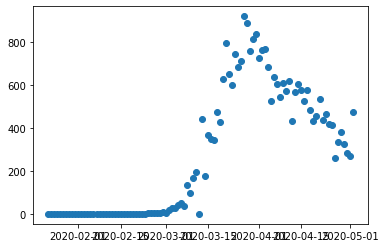

In [229]:
region = 'Italy'
data_dates, cum_cases, cum_deaths = data.load_time_series(region)
deaths = np.insert(np.diff(cum_deaths),0,cum_deaths[0])
plt.plot_date(data_dates,deaths);

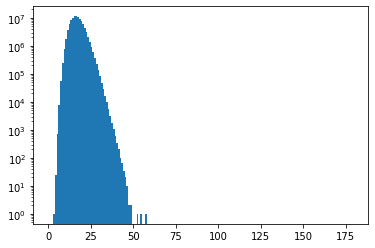

In [230]:
nD = 180
mu1 = 3.#5.1
vr1 = 0.86
sigma1 = vr1**2*mu1
mu2 = 14.#18.8
vr2 = 0.45
sigma2 = vr2**2*mu2
alpha1 = (mu1/sigma1)**2
alpha2 = (mu2/sigma2)**2
beta1 = sigma1**2/mu1
beta2 = sigma2**2/mu2
N =100000000
samples = np.random.gamma(alpha1,beta1,N)+np.random.gamma(alpha2,beta2,N)
counts, bins, patches = plt.hist(samples,bins=np.arange(nD),align='mid',log=True)

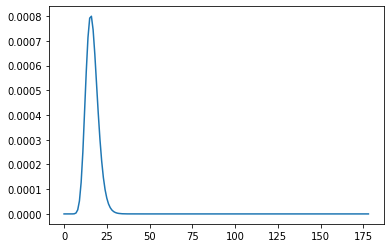

In [231]:
pdf = counts/sum(counts)*ifr
plt.plot(pdf);

In [232]:
def get_offset(pdf,threshold):
    cdf = np.cumsum(pdf)/np.sum(pdf)
    good = (1-cdf)<threshold
    offset = np.flatnonzero(good)[0]
    return offset

offset = get_offset(pdf,0.50)
offset

16

In [251]:
def infer_infections(region,pdf,maxpertfac=1.0,nTrials=100,neglect=0):
    data_dates, cum_cases, cum_deaths = data.load_time_series(region)
    deaths = np.insert(np.diff(cum_deaths),0,cum_deaths[0])
    if neglect:
        deaths = deaths[:-neglect]
        data_dates = data_dates[:-neglect]

    ifr = 0.007
    nOffDays = 0  # Initial days with zero chance of death
    nDays = len(deaths)   

    counts = pdf[:nDays]
    pdf = counts/sum(counts)*ifr

    infections = np.zeros((nDays-nOffDays));  # Infection cases time series (to be estimated)
    
    I = np.eye(nDays-nOffDays)
    z = np.zeros(nDays-nOffDays)
    dd  = deaths[nOffDays:];        # Trim the daily death vector to match A/A0
    b = np.hstack((dd,z))

    for iTry in range(nTrials):
        row = np.zeros(nDays); row[0] = pdf[0]
        M0  = linalg.toeplitz(pdf, row);   # Convolution matrix without perturbation
        if nOffDays>0:
            A0  = M0[nOffDays:, :-nOffDays];   # Trim convolution matrix if needed
        else:
            A0  = M0[nOffDays:, :];   # Trim convolution matrix if needed
        pdf_pert = pdf*(1+np.random.uniform(-1,1,pdf.shape)*maxpertfac); # Perturb each day's fatality with uniformly distributed noise
        #pdf_pert = 2*pdf*np.random.uniform(0,1,pdf.shape)
        row = np.zeros(nDays); row[0] = pdf_pert[0]
        M   = linalg.toeplitz(pdf_pert, row); # Perturbed convolution matrix
        if nOffDays>0:
            A   = M[nOffDays:, :-nOffDays]; # Trim convolution matrix if needed
        else:
            A   = M[nOffDays:, :]; # Trim convolution matrix if needed
        regs = np.linspace(1e-4,1e-2) # Regularization parameter search range
        errs = np.zeros_like(regs)     # Measure of fit for each reg param value
        for i, reg in enumerate(regs):
            L = np.vstack((A,reg*I)); 
            inIreg, _ = optimize.nnls(L,b)
            errs[i] = 10*np.abs( ifr*np.sum(inIreg)-np.sum(dd)) + np.sum(np.abs(np.abs(A@inIreg-dd)))
        reg = regs[np.argmin(errs)]
        L = np.vstack((A,reg*I)); 
        newinf, _ = optimize.nnls(L,b)
        infections += newinf/nTrials
    
    return data_dates, deaths, infections, M0

In [258]:
region = 'Spain'
data_dates, deaths, infections, M0 = infer_infections(region,counts,maxpertfac=0.5,nTrials=1000)
data_dates2, deaths2, infections2, M02 = infer_infections(region,counts,maxpertfac=0.5,nTrials=100)
#d2, deaths2, inf2 = infer_infections(region,counts,10)

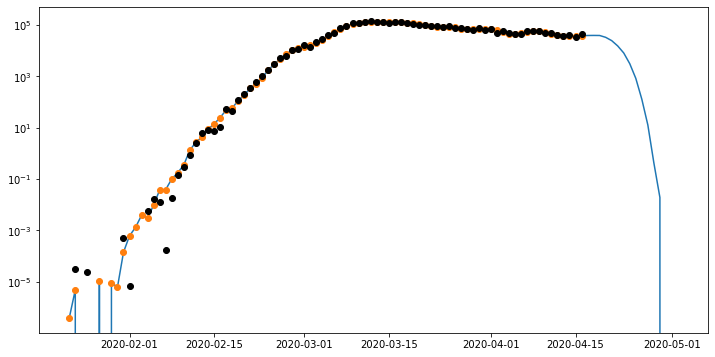

In [259]:
n=30
plt.figure(figsize=(12,6))
plt.plot_date(data_dates,infections,'-')
plt.plot_date(data_dates[:-offset],infections[:-offset],'o')
plt.plot_date(data_dates2[:-offset],infections2[:-offset],'ok')
plt.yscale('log')
#plt.plot_date(d2,inf2,'x')

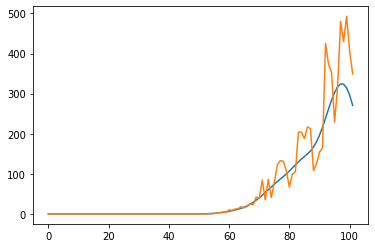

In [236]:
plt.plot(M0@infections)
plt.plot(deaths)

In [192]:
nDays

89

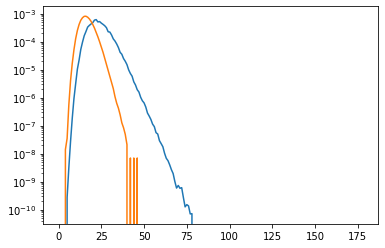

In [193]:
plt.semilogy(pdf_pert)
plt.semilogy(pdf)

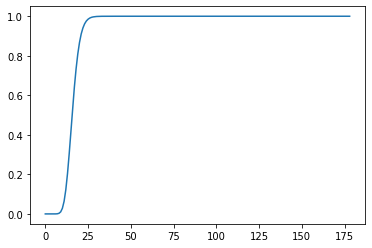

In [194]:
cdf = np.cumsum(pdf)/ifr
plt.plot(cdf)

In [196]:
1-cdf[25]

0.015119000000000105

26

In [205]:
cdf[26]

0.9908119999999999